## Import Libraries

In [1]:
# standard
import pandas as pd
import numpy as np
import random
import os
import cv2  # for resizing

# tf and keras
import tensorflow as tf
from tensorflow import keras
from keras import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder
import tensorflow_datasets as tfds
from tensorflow.keras.callbacks import EarlyStopping

# shap
import shap

# plots and images
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image

# others
import re
from sklearn.decomposition import PCA
from wordcloud import WordCloud
from collections import Counter
import warnings
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import GlobalAveragePooling2D

#silence TF
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


random.seed(2)
%matplotlib inline



In [2]:
# If using colab

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Connect to google drive

In [3]:
target_folder = "207 Machine Learning: Final Project"
found_path = None

for root, dirs, files in os.walk("/content/drive/MyDrive"):
    if target_folder in dirs:
        found_path = os.path.join(root, target_folder)
        break

if found_path:
    os.chdir(found_path)
    print("Changed working directory to:", os.getcwd())
else:
    print(f"Folder '{target_folder}' not found.")

Changed working directory to: /content/drive/.shortcut-targets-by-id/1MnqFmQYij3NcmwhbYUVc-9h4Dp6eLuMH/207 Machine Learning: Final Project


## Load images and labels

In [4]:
# with image, how to classfy image into 2 catogories

# FILL IN CODE HERE #
DATA_PATH = 'Data/Pictures/' # replace with your path

# how to transfer image to array from subfolder

img_size = (128,128) # Resize to smaller dimensions

def load_images_with_labels(folder_path):
    # Load CensusTract -> LILATracts_1And10 mapping

    images = []

    for subfolder in os.listdir(folder_path):
        img_subfolder = os.path.join(folder_path, subfolder)
        if os.path.isdir(img_subfolder):
            for filename in os.listdir(img_subfolder):
                img_path = os.path.join(img_subfolder, filename)
                if os.path.isfile(img_path) and filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                    try:
                        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(128, 128))
                        img_array = tf.keras.preprocessing.image.img_to_array(img).astype('float32')/255

                        # Extract file_id (assuming filename is CensusTract or similar)
                        file_id = os.path.splitext(filename)[0]

                        if file_id.startswith("0_"):
                            file_id = file_id[2:]  # remove the first two chars "0_"
                            y_label = 0
                        if file_id.startswith("1_"):
                            file_id = file_id[2:]  # remove the first two chars "1_"
                            y_label = 1
                        try:
                            file_id = int(file_id)  # convert to integer CensusTract
                        except ValueError:
                            continue  # skip if filename doesn't match a CensusTract format

                        images.append((img_array,y_label))
                    except Exception as e:
                        print(f"Failed to load {img_path}: {e}")

    return images


In [5]:
# Load images from the specified folder, get X and y

images = load_images_with_labels(DATA_PATH)
X = np.array([img[0] for img in images], dtype='float32')
Y = np.array([img[1] for img in images],dtype='float32')


## Split data into training and validation

In [6]:
#split data into training and validation sets

shuffled_index = np.random.permutation(len(X))
X, Y = X[shuffled_index], Y[shuffled_index]

# Split
X_train, X_temp, Y_train, Y_temp= train_test_split(X, Y, test_size=0.2, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

In [9]:

print("The shapes of X_train is", X_train.shape)
print("The shapes of Y_train is",Y_train.shape)
print("The shapes of X_val is",X_val.shape)
print("The shapes of Y_val is",Y_val.shape)
print("The shapes of X_test is",X_test.shape)
print("The shapes of Y_test is",Y_test.shape)


print("The type if X_train is", type(X_train))
print("The type if Y_train is", type(Y_train))
print("The type if X_val is", type(X_val))
print("The type if Y_val is", type(Y_val))
print("The type if X_test is", type(X_test))
print("The type if Y_test is", type(Y_test))


The shapes of X_train is (5696, 128, 128, 3)
The shapes of Y_train is (5696,)
The shapes of X_val is (712, 128, 128, 3)
The shapes of Y_val is (712,)
The shapes of X_test is (713, 128, 128, 3)
The shapes of Y_test is (713,)
The type if X_train is <class 'numpy.ndarray'>
The type if Y_train is <class 'numpy.ndarray'>
The type if X_val is <class 'numpy.ndarray'>
The type if Y_val is <class 'numpy.ndarray'>
The type if X_test is <class 'numpy.ndarray'>
The type if Y_test is <class 'numpy.ndarray'>


## CNN base line based on majority class

In [10]:
# Baseline
# When dealing with classification problems, a simple baseline is to select the *majority* class (the most common label in the training set) and use it as the prediction for all inputs.

print("1. The number of food desert in Y_train is",np.sum(Y_train==1))
print("2. The number of non-food desert in Y_train_mini is",np.sum(Y_train!=1))
print("3. The majority class in Y_train is non-food desert class.")
print("4. The accuracy of a majority class classifier for Y_train is", round(np.sum(Y_train!=1)/(np.sum(Y_train!=1)+np.sum(Y_train==1)),4))

1. The number of food desert in Y_train is 1250
2. The number of non-food desert in Y_train_mini is 4446
3. The majority class in Y_train is non-food desert class.
4. The accuracy of a majority class classifier for Y_train is 0.7805


## Build CNN model

In [11]:
# early stop setup
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [25]:
# create tensorflow CNN model
# Build CNN model
def create_cnn_model(input_shape):
    model = tf.keras.Sequential([

        #tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
        #tf.keras.layers.BatchNormalization(),
        #tf.keras.layers.MaxPooling2D((2,2)),

        tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2,2)),

        tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2,2)),

        # Flatten instead of Global pooling
        #tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Flatten(),

        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.2),  # Dropout to reduce overfitting
        tf.keras.layers.Dense(1, activation='sigmoid')  # Binary classification
    ])

    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),  # Slower learning rate for stability
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model



In [26]:
# train the model
input_shape = (128, 128, 3) # Assume the images are 400*400 with RGB colors
number_of_classes  = 1 # binary classfication
model = create_cnn_model(input_shape=input_shape)


history = model.fit(X_train,
                    Y_train,
                    validation_data=(X_val,Y_val),
                    epochs=10,
                    batch_size=32,
                    verbose=1,
                    callbacks = [early_stop])

Epoch 1/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.7027 - loss: 2.9773 - val_accuracy: 0.2149 - val_loss: 60.7433
Epoch 2/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.7784 - loss: 0.5469 - val_accuracy: 0.2149 - val_loss: 48.8501
Epoch 3/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.7738 - loss: 0.5205 - val_accuracy: 0.7247 - val_loss: 1.4459
Epoch 4/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.7858 - loss: 0.4553 - val_accuracy: 0.7851 - val_loss: 0.5511
Epoch 5/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.7764 - loss: 0.3931 - val_accuracy: 0.7851 - val_loss: 0.5914
Epoch 6/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.7884 - loss: 0.3234 - val_accuracy: 0.7851 - val_loss: 0.6811
Epoch 7/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.7757 - loss: 0.3193 - val_accuracy: 0.7851 - val_loss: 0.7045
Epoch 8/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.7778 - loss: 0.3045 - val_a

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7897 - loss: 0.5529
Validation Loss: 0.5511, Validation Accuracy: 0.7851


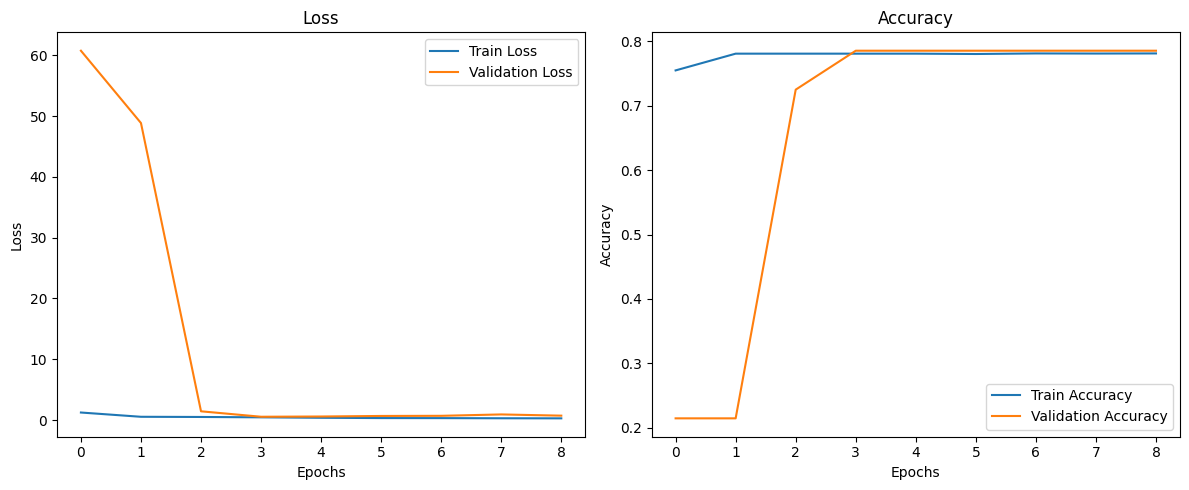

In [27]:
# Evaluate the model
loss,accuracy = model.evaluate(X_val,Y_val,verbose=1)

print(f"Validation Loss: {loss:.4f}, Validation Accuracy: {accuracy:.4f}")

# draw the training and validation loss and accuracy
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


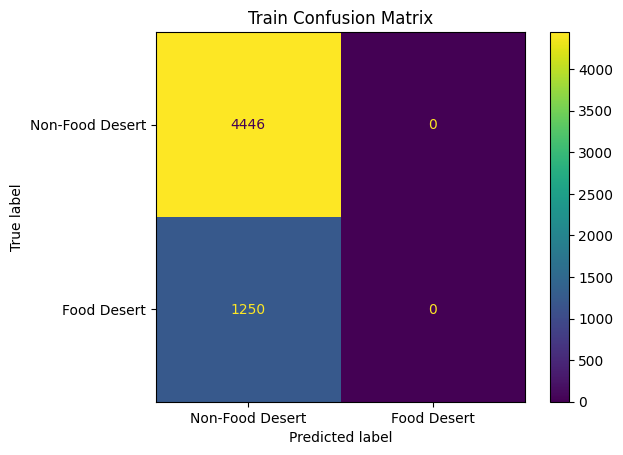

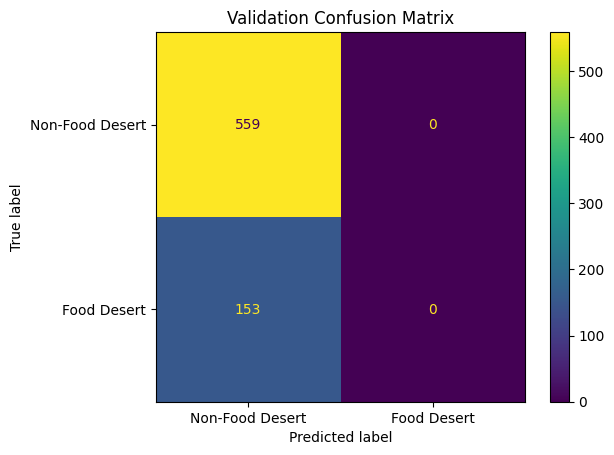

Training Data Results:
True Positives training (TP): 0
False Negatives training(FN): 1250
False Positives traniing(FP): 0
True Negatives traniing(TN): 4446
Validation Data Results:
True Positives validation (TP): 559
False Negatives validation(FN): 0
False Positives validation(FP): 153
True Negatives validation(TN): 0
The model does not have generalization capabilities. The accuracy are quite different between training and validation dataset.The training accuracy is nan. The testing accuracy is nan


In [29]:
Y_train_pred = model.predict(X_train)
Y_train_pred_classes = (Y_train_pred >= 0.5).astype(int)

Y_val_pred = model.predict(X_val)
Y_val_pred_classes = (Y_val_pred >= 0.5).astype(int)

train_cm = confusion_matrix(Y_train,Y_train_pred_classes)
table_validation= ConfusionMatrixDisplay(confusion_matrix=train_cm, display_labels=['Non-Food Desert', 'Food Desert'])
table_validation.plot()
table_validation.ax_.set_title('Train Confusion Matrix')
plt.show()

validation_cm = confusion_matrix(Y_val,Y_val_pred_classes)
table_validation= ConfusionMatrixDisplay(confusion_matrix=validation_cm, display_labels=['Non-Food Desert', 'Food Desert'])
table_validation.plot()
table_validation.ax_.set_title('Validation Confusion Matrix')
plt.show()

# print results
TN_training, FP_training, FN_training, TP_training = train_cm.ravel()
print("Training Data Results:")
print(f"True Positives training (TP): {TP_training}")
print(f"False Negatives training(FN): {FN_training}")
print(f"False Positives traniing(FP): {FP_training}")
print(f"True Negatives traniing(TN): {TN_training}")

TN_validation, FP_validation, FN_validation, TP_validation = validation_cm.ravel()

print("Validation Data Results:")
print(f"True Positives validation (TP): {TN_validation}")
print(f"False Negatives validation(FN): {FP_validation}")
print(f"False Positives validation(FP): {FN_validation}")
print(f"True Negatives validation(TN): {TP_validation}")


accuracy_training_tp = (TP_training/(TP_training+FP_training))
accuracy_validation_tp = (TP_validation/(TP_validation+FP_validation))
print(f"The model does not have generalization capabilities. The accuracy are quite different between training and validation dataset.The training accuracy is {accuracy_training_tp:.2f}. The testing accuracy is {accuracy_validation_tp:.2f}")



In [ ]:
# The model assume all of the prediction falls into non-food desert. Therefore, the largest validation accuracy will be close to majority base line class.